In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Set to True to force a full refresh of the data
full_refresh = True

In [3]:
repo_root = os.popen('git rev-parse --show-toplevel').read().strip()

In [4]:
data_folder = os.path.join(repo_root, 'multi-parameter-estimation', 'data')

# Get list of data directories
data_dirs = os.listdir(data_folder)
data_dirs = [d for d in data_dirs if os.path.isdir(os.path.join(data_folder, d))]

# skip old-data
if 'old-data' in data_dirs:
    data_dirs.remove('old-data')

data_dirs.sort()
data_dirs

['2025-05-30--14h-02m-13s',
 '2025-05-30--14h-03m-06s',
 '2025-05-30--14h-04m-07s',
 '2025-05-30--14h-05m-08s',
 '2025-05-30--14h-19m-25s',
 '2025-05-30--14h-22m-01s',
 '2025-05-30--14h-24m-36s',
 '2025-05-30--14h-27m-02s',
 '2025-05-30--14h-43m-17s',
 '2025-05-30--14h-48m-08s',
 '2025-05-30--14h-52m-48s',
 '2025-05-30--14h-57m-52s']

In [5]:
new_data_dirs = data_dirs.copy()

if not full_refresh:
    for d in data_dirs:
        if os.path.exists(os.path.join(data_folder, d, "chunked_coincidences_n=40.csv")):
            new_data_dirs.remove(d)

new_data_dirs

['2025-05-30--14h-02m-13s',
 '2025-05-30--14h-03m-06s',
 '2025-05-30--14h-04m-07s',
 '2025-05-30--14h-05m-08s',
 '2025-05-30--14h-19m-25s',
 '2025-05-30--14h-22m-01s',
 '2025-05-30--14h-24m-36s',
 '2025-05-30--14h-27m-02s',
 '2025-05-30--14h-43m-17s',
 '2025-05-30--14h-48m-08s',
 '2025-05-30--14h-52m-48s',
 '2025-05-30--14h-57m-52s']

In [6]:
def load_coincidences(data_dir):
    coincidences = pd.read_csv(os.path.join(data_folder, data_dir, "scaled_coincidences.csv"))
    coincidences["data_dir"] = data_dir
    return coincidences

scaled_coincidences_df = pd.concat([load_coincidences(d) for d in new_data_dirs], ignore_index=True)
scaled_coincidences_df 

,data_dir,repetition,C,DB_H,DB_V,SB,N
0,2025-05-30--14h-02m-13s,0,0.0,1.0,0.0,0.0,1.0
1,2025-05-30--14h-02m-13s,1,0.0,4.0,0.0,0.0,4.0
2,2025-05-30--14h-02m-13s,2,0.0,2.0,0.0,0.0,2.0
3,2025-05-30--14h-02m-13s,3,0.0,2.0,0.0,0.0,2.0
4,2025-05-30--14h-02m-13s,5,0.0,4.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...
24057,2025-05-30--14h-57m-52s,3995,0.0,5.0,0.0,0.0,5.0
24058,2025-05-30--14h-57m-52s,3996,0.0,4.0,0.0,0.0,4.0
24059,2025-05-30--14h-57m-52s,3997,0.0,2.0,0.0,0.0,2.0
24060,2025-05-30--14h-57m-52s,3998,0.0,2.0,0.0,0.0,2.0


count    24062.000000
mean         2.661312
std          1.427364
min          0.500000
25%          1.500000
50%          2.500000
75%          3.500000
max         11.000000
Name: N, dtype: float64

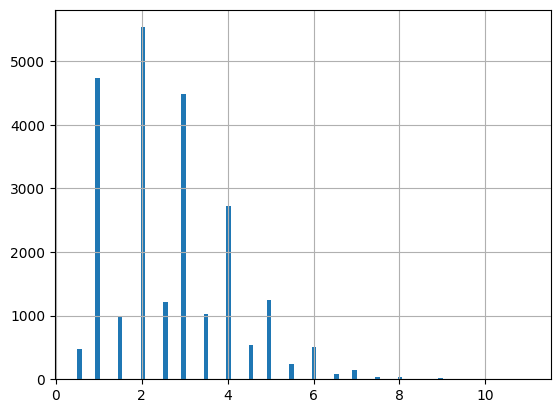

In [7]:
#plot the distribution fo N
scaled_coincidences_df['N'].hist(bins=100)
scaled_coincidences_df['N'].describe()


In [8]:
# average N
np.average(scaled_coincidences_df["N"])

np.float64(2.6613124428559556)

In [9]:
chunks = []
target_N = 40

# Group the DataFrame by 'data_dir'
for data_dir, group_df in scaled_coincidences_df.groupby('data_dir'):
    group_df = group_df.reset_index(drop=True)
    N_values = group_df['N'].values
    used = np.zeros(len(group_df), dtype=bool)

    while True:
        current_indices = []
        current_sum = 0
        made_progress = False

        for i in range(len(N_values)):
            if used[i]:
                continue

            n_val = N_values[i]
            if current_sum + n_val > target_N + 1:
                continue

            current_indices.append(i)
            current_sum += n_val
            used[i] = True
            made_progress = True

            # Accept if sum is within [target_N - 1, target_N + 1]
            if target_N - 1 <= current_sum <= target_N + 1:
                chunk_df = group_df.iloc[current_indices]
                chunks.append(chunk_df)
                break

        if not (target_N - 1 <= current_sum <= target_N + 1):
            # Undo used marking
            used[current_indices] = False

        if not made_progress or not (target_N - 1 <= current_sum <= target_N + 1):
            break

# Summarize chunks
chunk_summaries = []

for chunk in chunks:
    summary = chunk.sum(numeric_only=True)
    summary['data_dir'] = chunk['data_dir'].iloc[0]
    chunk_summaries.append(summary)

# Combine all summaries into a DataFrame
result_df = pd.DataFrame(chunk_summaries)

# Drop the 'repetition' column if it exists
result_df = result_df.drop(columns=['repetition'], errors='ignore')

# Reorder columns
cols = ['data_dir'] + [col for col in result_df.columns if col != 'data_dir']
result_df = result_df[cols]

result_df


,data_dir,C,DB_H,DB_V,SB,N
0,2025-05-30--14h-02m-13s,2.0,37.0,0.0,0.0,39.0
1,2025-05-30--14h-02m-13s,0.0,39.0,0.0,0.0,39.0
2,2025-05-30--14h-02m-13s,0.5,40.0,0.0,0.0,40.5
3,2025-05-30--14h-02m-13s,1.0,38.0,0.0,0.0,39.0
4,2025-05-30--14h-02m-13s,0.5,40.0,0.0,0.0,40.5
...,...,...,...,...,...,...
1594,2025-05-30--14h-57m-52s,1.0,36.0,0.0,2.0,39.0
1595,2025-05-30--14h-57m-52s,0.0,37.0,0.0,3.5,40.5
1596,2025-05-30--14h-57m-52s,0.5,35.0,0.0,3.5,39.0
1597,2025-05-30--14h-57m-52s,0.5,35.0,0.0,4.0,39.5


In [10]:
# save the dataframes to csv files based on the data_dir
for data_dir in new_data_dirs:
    df_subset = result_df[result_df["data_dir"] == data_dir]
    if not df_subset.empty:
        output_file = os.path.join(data_folder, data_dir, "chunked_coincidences_n=40.csv")
        df_subset.to_csv(output_file, index=False)
        print(f"Saved {output_file}")

Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-05-30--14h-02m-13s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-05-30--14h-03m-06s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-05-30--14h-04m-07s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-05-30--14h-05m-08s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/RES_EPS_EMQL/projects/multi-parameter-estimation/multi-parameter-estimation/data/2025-05-30--14h-19m-25s/chunked_coincidences_n=40.csv
Saved /home/jh115/Heriot-Watt University Team Dropbox/R